In [101]:
gene_expr_bed = "/Users/sabrinami/Library/CloudStorage/Box-Box/imlab-data/data-Github/rat-genomic-analysis/Enformer-Predictions/data/Brain.rn7.expr.tpm.bed"

import pandas as pd
import numpy as np
obs_gene_expr = pd.read_csv(gene_expr_bed, sep="\t", header=0, index_col='gene_id')

/var/folders/1q/nqyt2x9s071fkn235hfq1p680000gn/T/ipykernel_33538/2078132498.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  obs_gene_expr = pd.read_csv(gene_expr_bed, sep="\t", header=0, index_col='gene_id')


In [102]:
## TEMPORARILY SUBSET OBS GENE EXPR DATA TO INDIVIDUALS IN BOX FOLDER
import os
predictions_dir = "/Users/sabrinami/Library/CloudStorage/Box-Box/imlab-data/data-Github/rat-genomic-analysis/Enformer-Predictions/predictions"
individuals = [file for file in os.listdir(predictions_dir)]
obs_gene_expr = obs_gene_expr[individuals]




In [103]:
gene_list = ['ENSRNOG00000001342', 'ENSRNOG00000020624', 'ENSRNOG00000058006', 'ENSRNOG00000060045']
#print(obs_gene_expr.loc[gene_list])

pred_vs_obs = {}
for gene in gene_list:
    obs = obs_gene_expr.loc[gene][3:]
    pred_vs_obs[gene] = pd.DataFrame({"observed": obs, "predicted": np.zeros(obs.shape)})

In [104]:
def compute_tss_bin(output_window_coords_resized, tss_position, output_length=114688, bin_length=128, rc=False):
    '''
    Computes the bin index of the enformer output bin containing the TSS
    Inputs:
    output_window_coords_resized: Kipoiseq interval for the output window of Enformer, should already be resized to the model output window size
    tss_position: absolute location of TSS
    output_length: Length of output window in base pairs
    bin_size: Length of output bins in base pairs
    Outputs:
    tss_bin: Index of bin containing TSS
    '''
    try:
        relative_position = int(tss_position) - int(output_window_coords_resized.start)
    except:
    # print(tss_position)
    # print(output_window_coords_resized.start)
        sys.exit()

    if relative_position < 0 or relative_position > output_length:
        # print(tss_position, "appears to be out of bounds for output window: ",output_window_coords_resized)
        return None 
    else:
        center = relative_position // bin_length

        
        if rc:
            number_of_bins = int(output_length/bin_length)
            new_center = number_of_bins - 1 - center
            # print(new_center)
            return [new_center-1,new_center,new_center+1]
        else:
            # print(center)
            return [center-1,center,center+1]

In [36]:
annot_df = pd.read_csv("/Users/sabrinami/Library/CloudStorage/Box-Box/imlab-data/data-Github/rat-genomic-analysis/Enformer-Predictions/data/rn7.gene.txt", sep="\t", index_col='geneId')
print(annot_df.loc[gene_list])

                            geneSymbol chromosome      start        end  \
geneId                                                                    
ENSRNOG00000001342  ENSRNOG00000001342         12   33261476   33293932   
ENSRNOG00000020624              Acadsb          1  186188987  186230379   
ENSRNOG00000058006                Sncg         16    9700514    9705368   
ENSRNOG00000060045               Pi4ka         11   83609069   83724080   

                   strand        tss  \
geneId                                 
ENSRNOG00000001342      -   33293932   
ENSRNOG00000020624      +  186188987   
ENSRNOG00000058006      -    9705368   
ENSRNOG00000060045      +   83609069   

                                                     description  hasEqtl  \
geneId                                                                      
ENSRNOG00000001342     cilia and flagella associated protein 251     True   
ENSRNOG00000020624  acyl-CoA dehydrogenase, short/branched chain     True   


/var/folders/1q/nqyt2x9s071fkn235hfq1p680000gn/T/ipykernel_33538/1256236689.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  annot_df = pd.read_csv("/Users/sabrinami/Library/CloudStorage/Box-Box/imlab-data/data-Github/rat-genomic-analysis/Enformer-Predictions/data/rn7.gene.txt", sep="\t", index_col='geneId')


In [105]:
import kipoiseq # for manipulating fasta files
from kipoiseq import Interval # same as above, really
import sys
import h5py
predictions_dir = "/Users/sabrinami/Library/CloudStorage/Box-Box/imlab-data/data-Github/rat-genomic-analysis/Enformer-Predictions/predictions"

for gene in gene_list:
    print(gene)
    gene_annot = annot_df.loc[gene]
    interval_obj = Interval("chr" + str(gene_annot['chromosome']), gene_annot['start'], gene_annot['end'])
    tss_bins = compute_tss_bin(interval_obj.resize(114688), gene_annot['tss'])
    if tss_bins is None:
        print("Skipping", gene)
        continue
    interval = f"chr{gene_annot['chromosome']}_{gene_annot['start']}_{gene_annot['end']}"
    i=0
    for individual in pred_vs_obs[gene].index:
        predictions = h5py.File(f"{predictions_dir}/{individual}/haplotype1/{interval}_predictions.h5", "r")
        matrix = predictions[interval][()]
        extra_bins =  [tss_bins[0] - 1] + tss_bins + [tss_bins[2] + 1]
        if i < 5:
            print(matrix[extra_bins, 4980])
            i += 1
        pred_expr = np.average(matrix[tss_bins, 4980])
        pred_vs_obs[gene].loc[individual, "predicted"] = pred_expr

    


ENSRNOG00000001342
[0.00573737 0.00508188 0.00727259 0.00560077 0.0076798 ]
[0.00573869 0.00508314 0.00727495 0.00560294 0.00768098]
[0.00573627 0.00507914 0.0072732  0.00559864 0.00767822]
[0.00573627 0.00507914 0.0072732  0.00559864 0.00767822]
[0.00573737 0.00508188 0.00727259 0.00560077 0.0076798 ]
ENSRNOG00000020624
[5.7827654  4.293017   7.8872423  0.10644712 0.05631344]
[5.7827654  4.293017   7.8872423  0.10644712 0.05631344]
[5.7819533  4.290507   7.8848658  0.10634203 0.05630142]
[5.7819533  4.290507   7.8848658  0.10634203 0.05630142]
[5.7819533  4.290507   7.8848658  0.10634203 0.05630142]
ENSRNOG00000058006
[1.42411528e+01 5.73353358e-02 1.29730888e-02 9.69883148e-03
 1.51052885e-02]
[1.42411528e+01 5.73353358e-02 1.29730888e-02 9.69883148e-03
 1.51052885e-02]
[1.42411528e+01 5.73353358e-02 1.29730888e-02 9.69883148e-03
 1.51052885e-02]
[1.4251710e+01 5.7409633e-02 1.2985041e-02 9.7029284e-03 1.5121926e-02]
[1.42411528e+01 5.73353358e-02 1.29730888e-02 9.69883148e-03
 1.510

In [106]:
print(pred_vs_obs.keys())

dict_keys(['ENSRNOG00000001342', 'ENSRNOG00000020624', 'ENSRNOG00000058006', 'ENSRNOG00000060045'])


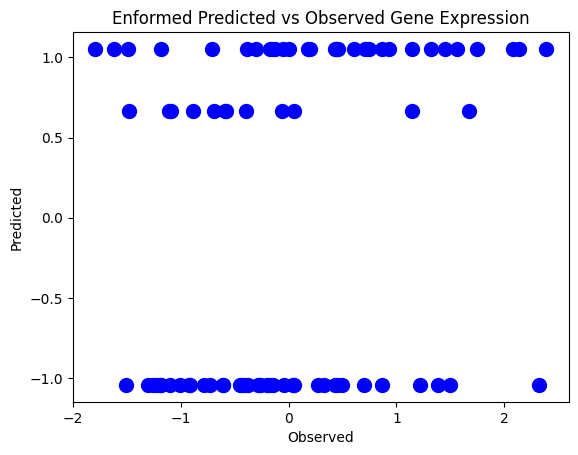

In [116]:
import matplotlib.pyplot as plt
df = pred_vs_obs['ENSRNOG00000020624']


from scipy.stats import zscore
x = zscore(df['observed'])
y = zscore(df['predicted'])
# Create the dot plot
plt.scatter(x, y, color='blue', marker='o', s=100)




# Add labels and title
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.title('Enformed Predicted vs Observed Gene Expression')

# Show the plot
plt.show()

### How we could improve plots:

* Use all 340 individuals (instead of the 80 that I moved to Box before polaris shut down)
* Rerun predictions with sequences centered at TSS (instead of gene start and end)
* The upside is that the Enformer predictions so far agree with basic expectations:
    * There is variation in predicted gene expression between individuals (although slim)
    * CAGE expression peaks around TSS and tapers off



### Extra Plots

In [117]:
predixcan = '/Users/sabrinami/Library/CloudStorage/Box-Box/imlab-data/data-Github/rat-genomic-analysis/PTRS-Analysis/RatXcan/Results/Br_EN__predict.txt'
pred_gene_expr = pd.read_csv(predixcan, sep="\t", header=0, index_col='IID')
pred_gene_expr = pred_gene_expr.loc[individuals]



ValueError: Invalid file path or buffer object type: <class 'numpy.float32'>

In [112]:
print(pred_gene_expr[[gene]].join(df['predicted'], how='inner'))

            ENSRNOG00000060045  predicted
00077E90D8            1.286916   4.095569
00078997FE            0.011189   4.095569
00079FF7D6            2.644286   4.093905
00078A1A62            0.009481   4.093905
000792A3F9            2.646413   4.093905
...                        ...        ...
00078A072C            0.009487   4.093905
000792A07E            1.288204   4.095264
000792A420            1.370338   4.093905
00078997BF            0.009408   4.093905
00077E7666            0.010847   4.095569

[80 rows x 2 columns]


            ENSRNOG00000020624  predicted
00077E90D8            0.063201   4.095569
00078997FE            2.460128   4.095569
00079FF7D6            1.236296   4.093905
00078A1A62            1.232606   4.093905
000792A3F9            2.460731   4.093905
...                        ...        ...
00078A072C            1.262563   4.093905
000792A07E            0.035041   4.095264
000792A420            0.008059   4.093905
00078997BF            1.236304   4.093905
00077E7666            1.260766   4.095569

[80 rows x 2 columns]


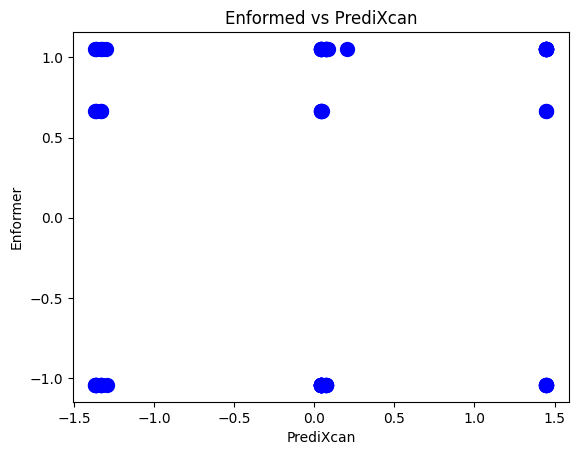

In [115]:
gene = 'ENSRNOG00000020624'
df = pred_vs_obs[gene]
df = pred_gene_expr[[gene]].join(df['predicted'], how = 'inner')
print(df)

from scipy.stats import zscore
x = zscore(df[gene])
y = zscore(df['predicted'])
# Create the dot plot
plt.scatter(x, y, color='blue', marker='o', s=100)



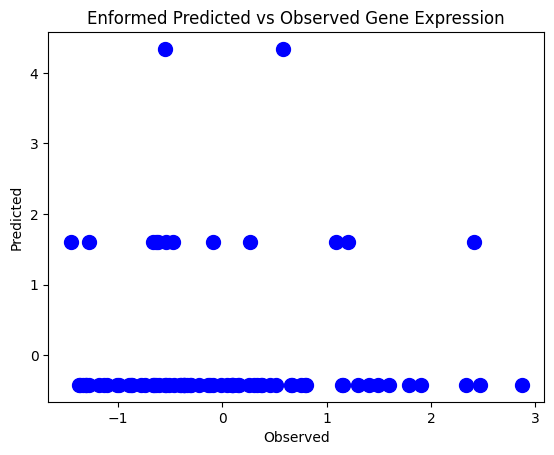

In [89]:
df = pred_vs_obs['ENSRNOG00000001342']


from scipy.stats import zscore
x = zscore(df['observed'])
y = zscore(df['predicted'])
# Create the dot plot
plt.scatter(x, y, color='blue', marker='o', s=100)




# Add labels and title
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.title('Enformed Predicted vs Observed Gene Expression')

# Show the plot
plt.show()

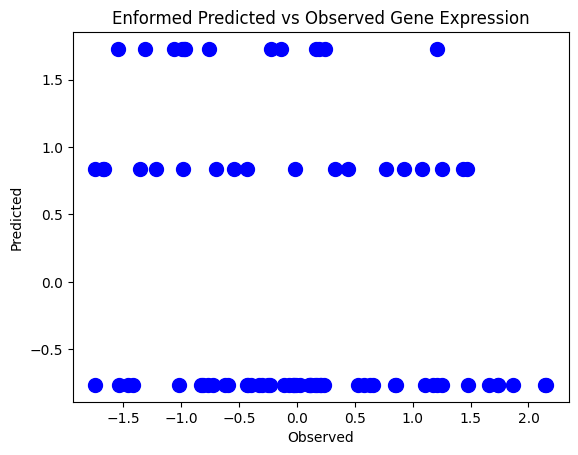

In [90]:
import matplotlib.pyplot as plt
df = pred_vs_obs['ENSRNOG00000058006']


from scipy.stats import zscore
x = zscore(df['observed'])
y = zscore(df['predicted'])
# Create the dot plot
plt.scatter(x, y, color='blue', marker='o', s=100)




# Add labels and title
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.title('Enformed Predicted vs Observed Gene Expression')

# Show the plot
plt.show()